In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 700,700
from tabs import DihedralInfoFromTorsionLib
from tabs import custom
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from helpers import GetTabsPopulationMatrix, CheckForCorrelationCandidates
import pandas as pd
import warnings

In [2]:
plt.rcParams["font.size"] = 14

Reading in the macrocycle

In [3]:
mol = Chem.MolFromMolFile("../Data/Tests/macrocycle.sdf",removeHs=False)

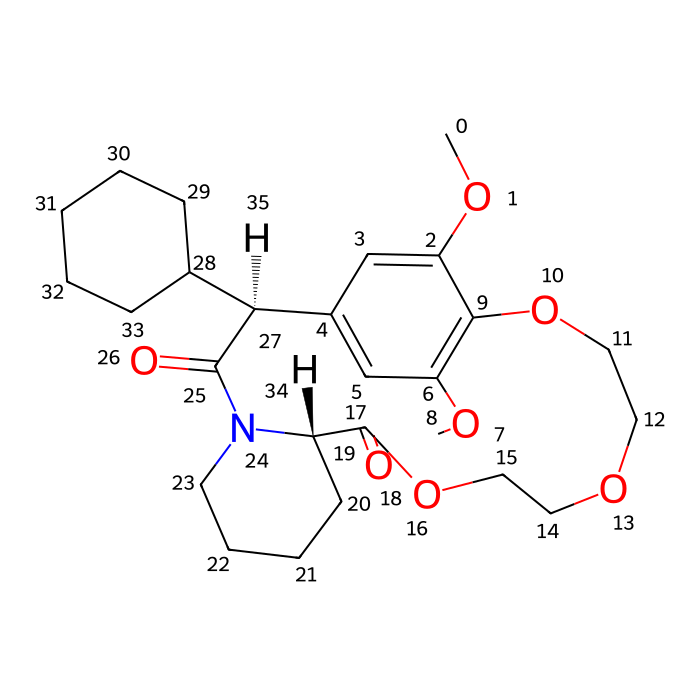

In [4]:
rdDepictor.SetPreferCoordGen(True)
mol.RemoveAllConformers()
Chem.RemoveHs(mol)

Getting the experimental torsion information matched through the ET terms in the ETKDG and also add additional dihedrals of interest

In [6]:
etInfo = DihedralInfoFromTorsionLib(mol)
# get indices where TorsionType is MACROCYCLE
macrocycle_indices = [i for i, torsion in enumerate(etInfo.torsionTypes) if torsion == 3]
mcDihedrals = etInfo.indices[15:]
mcDihedrals.append([2,9,10,11])
mcDihedrals.append([3,4,27,25])
mcDihedrals.append([24,19,17,16])
mcDihedrals

[[27, 25, 24, 19],
 [18, 17, 16, 15],
 [17, 16, 15, 14],
 [11, 12, 13, 14],
 [15, 14, 13, 12],
 [12, 11, 10, 9],
 [10, 11, 12, 13],
 [13, 14, 15, 16],
 [4, 27, 25, 26],
 [2, 9, 10, 11],
 [3, 4, 27, 25],
 [24, 19, 17, 16]]

Correlation Analysis

The original data can be found in xxx

Reading in the already extracted metadata (dihedral profiles).

In [7]:
import pickle

In [8]:
profiles = pickle.load(open("../Data/Tests/macrocycleDihedralProfiles.pkl", "rb"))

In [9]:
profiles.keys()

dict_keys([(27, 25, 24, 19), (18, 17, 16, 15), (17, 16, 15, 14), (11, 12, 13, 14), (15, 14, 13, 12), (12, 11, 10, 9), (10, 11, 12, 13), (13, 14, 15, 16), (4, 27, 25, 26), (2, 9, 10, 11), (3, 4, 27, 25), (24, 19, 17, 16)])

Check which profiles only exhibit one state as they are then not of interest

In [10]:
idxs = CheckForCorrelationCandidates(mol, mcDihedrals, profiles, threshold=1)

Dihedral [27, 25, 24, 19] not relevant: [6.99965002e-02 9.99300035e+01]
Dihedral [18, 17, 16, 15] not relevant: [99.08504575  0.91495425]
Dihedral [13, 14, 15, 16] not relevant: [47.49762512  0.50497475 51.99740013]
Dihedral [4, 27, 25, 26] not relevant: [9.99350032e+01 6.49967502e-02]
Dihedral [3, 4, 27, 25] not relevant: [100.]


Writing out all possible pairs

In [11]:
# get all pairs of dihedrals
pairs = []
for i in range(len(idxs)):
    for j in range(i+1, len(idxs)):
        pairs.append((idxs[i], idxs[j]))

In [25]:
pValues = []
for pairIndex in range(len(pairs)):
    # join the two arrays into one 2D array
    tmp = profiles[tuple(pairs[pairIndex][0])]
    tmp = np.hstack([tmp, profiles[tuple(pairs[pairIndex][1])]])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        # code that emits warnings    
        info2 = custom.CustomDihedralInfo(mol, pairs[pairIndex], tmp, showFits=False)
    tabsPopulationTraj = info2.GetTABS(confTorsions=tmp)
    # count the number for each unique value
    unique, counts = np.unique(tabsPopulationTraj, return_counts=True)
    # percentage of each unique value
    percentages = counts / len(tabsPopulationTraj) * 100
    m = GetTabsPopulationMatrix(unique, counts)
    res = chi2_contingency(m)
    pValues.append((pairs[pairIndex][0], pairs[pairIndex][1], res.statistic, res.pvalue))
res = pd.DataFrame(pValues, columns=["Dihedral A", "Dihedral B", "stats", "p-value"])

In [26]:
res

,Dihedral A,Dihedral B,stats,p-value
0,"[17, 16, 15, 14]","[11, 12, 13, 14]",701.290352,1.831638e-150
1,"[17, 16, 15, 14]","[15, 14, 13, 12]",10657.775378,0.000000e+00
2,"[17, 16, 15, 14]","[12, 11, 10, 9]",671.231540,1.753570e-146
3,"[17, 16, 15, 14]","[10, 11, 12, 13]",431.951793,1.595364e-94
4,"[17, 16, 15, 14]","[2, 9, 10, 11]",599.516498,6.556115e-131
5,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00
6,"[11, 12, 13, 14]","[15, 14, 13, 12]",1040.237211,6.796672e-224
7,"[11, 12, 13, 14]","[12, 11, 10, 9]",8888.799601,0.000000e+00
8,"[11, 12, 13, 14]","[10, 11, 12, 13]",7747.287534,0.000000e+00
9,"[11, 12, 13, 14]","[2, 9, 10, 11]",8090.744194,0.000000e+00


As the target dihedral is known, we can filter for the correlations with (24, 19, 17, 16)

In [27]:
res.sort_values(by="p-value", ascending=True, inplace=False)
target = [24, 19, 17, 16]
sub = res[res["Dihedral B"].apply(lambda x: x == target)]

In [28]:
sub.sort_values(by="stats", ascending=True, inplace=False)

,Dihedral A,Dihedral B,stats,p-value
17,"[12, 11, 10, 9]","[24, 19, 17, 16]",0.612005,4.340339e-01
20,"[2, 9, 10, 11]","[24, 19, 17, 16]",2.967339,8.496151e-02
10,"[11, 12, 13, 14]","[24, 19, 17, 16]",130.576662,4.422197e-29
19,"[10, 11, 12, 13]","[24, 19, 17, 16]",138.016584,7.227070e-32
14,"[15, 14, 13, 12]","[24, 19, 17, 16]",770.460423,4.973303e-168
5,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00


Checking in detail on the highest correlated pair

In [29]:
indicesOfInterest = [[24,19,17,16],
                     [17,16,15,14]]

In [32]:
tmp = profiles[tuple(indicesOfInterest[0])]
customProfiles = np.hstack([tmp, profiles[tuple(indicesOfInterest[1])]])

In [33]:
binsize = np.pi*2/36
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles,binsize)

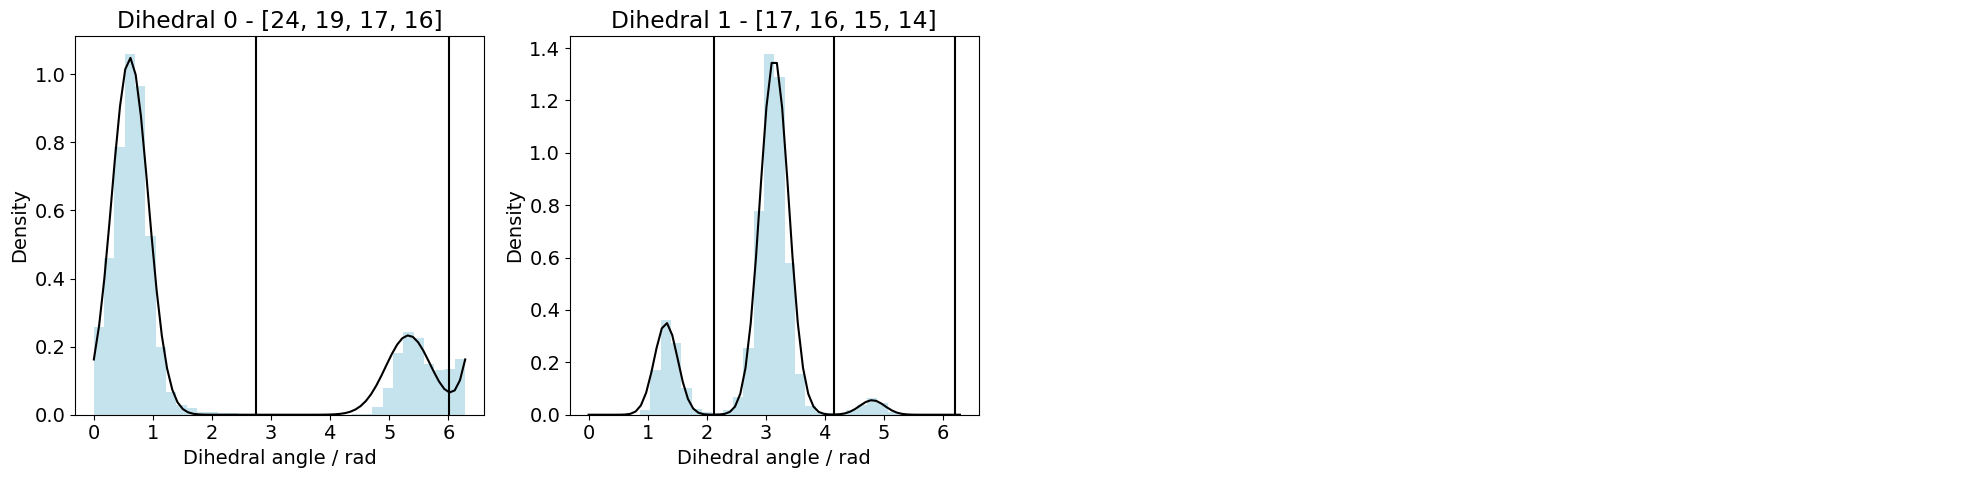

In [35]:
info2 = custom.CustomDihedralInfo(mol, indicesOfInterest, customProfiles, showFits=True)

Text(0, 0.5, 'Density')

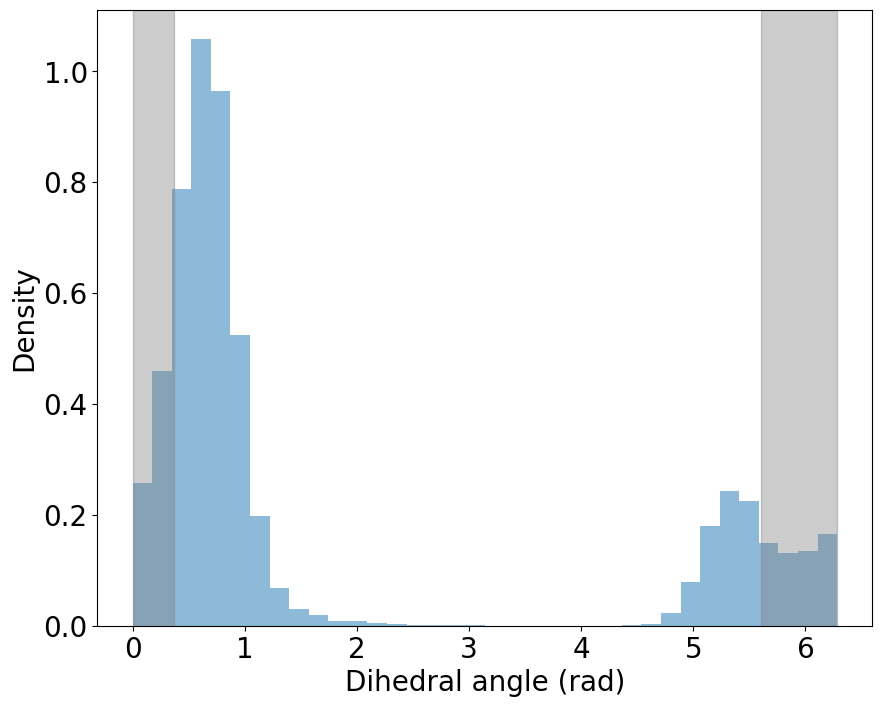

In [36]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(xHist, yHists[0], width=binsize, alpha=0.5)
#ax.vlines(np.deg2rad(21),0,1.1, color='red', linestyle='--')
#ax.vlines(np.deg2rad(321),0,1.1, color='red', linestyle='--')
ax.axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax.axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax.set_xlabel("Dihedral angle (rad)")
ax.set_ylabel("Density")

In [37]:
tabsPopulationTraj = info2.GetTABS(confTorsions=customProfiles)

In [38]:
# count the number for each unique value
unique, counts = np.unique(tabsPopulationTraj, return_counts=True)

In [39]:
print(unique, counts)

[11 12 13 21 22 23] [ 3362 12658   125    12  3321   523]


In [40]:
GetTabsPopulationMatrix(unique, counts)

array([[ 3362, 12658,   125],
       [   12,  3321,   523]])

In [41]:
tabsPopulationTraj[0]

12

In [42]:
#get all indices of the TABS that have 1 as the first value
indices1 = []
indices2 = []
for i in range(len(tabsPopulationTraj)):
    if str(tabsPopulationTraj[i]).startswith("1"):
        indices1.append(i)
    if str(tabsPopulationTraj[i]).startswith("2"):
        indices2.append(i)

In [43]:
binsize = np.pi*2/36

Text(0.5, 0, 'Dihedral angle (rad)')

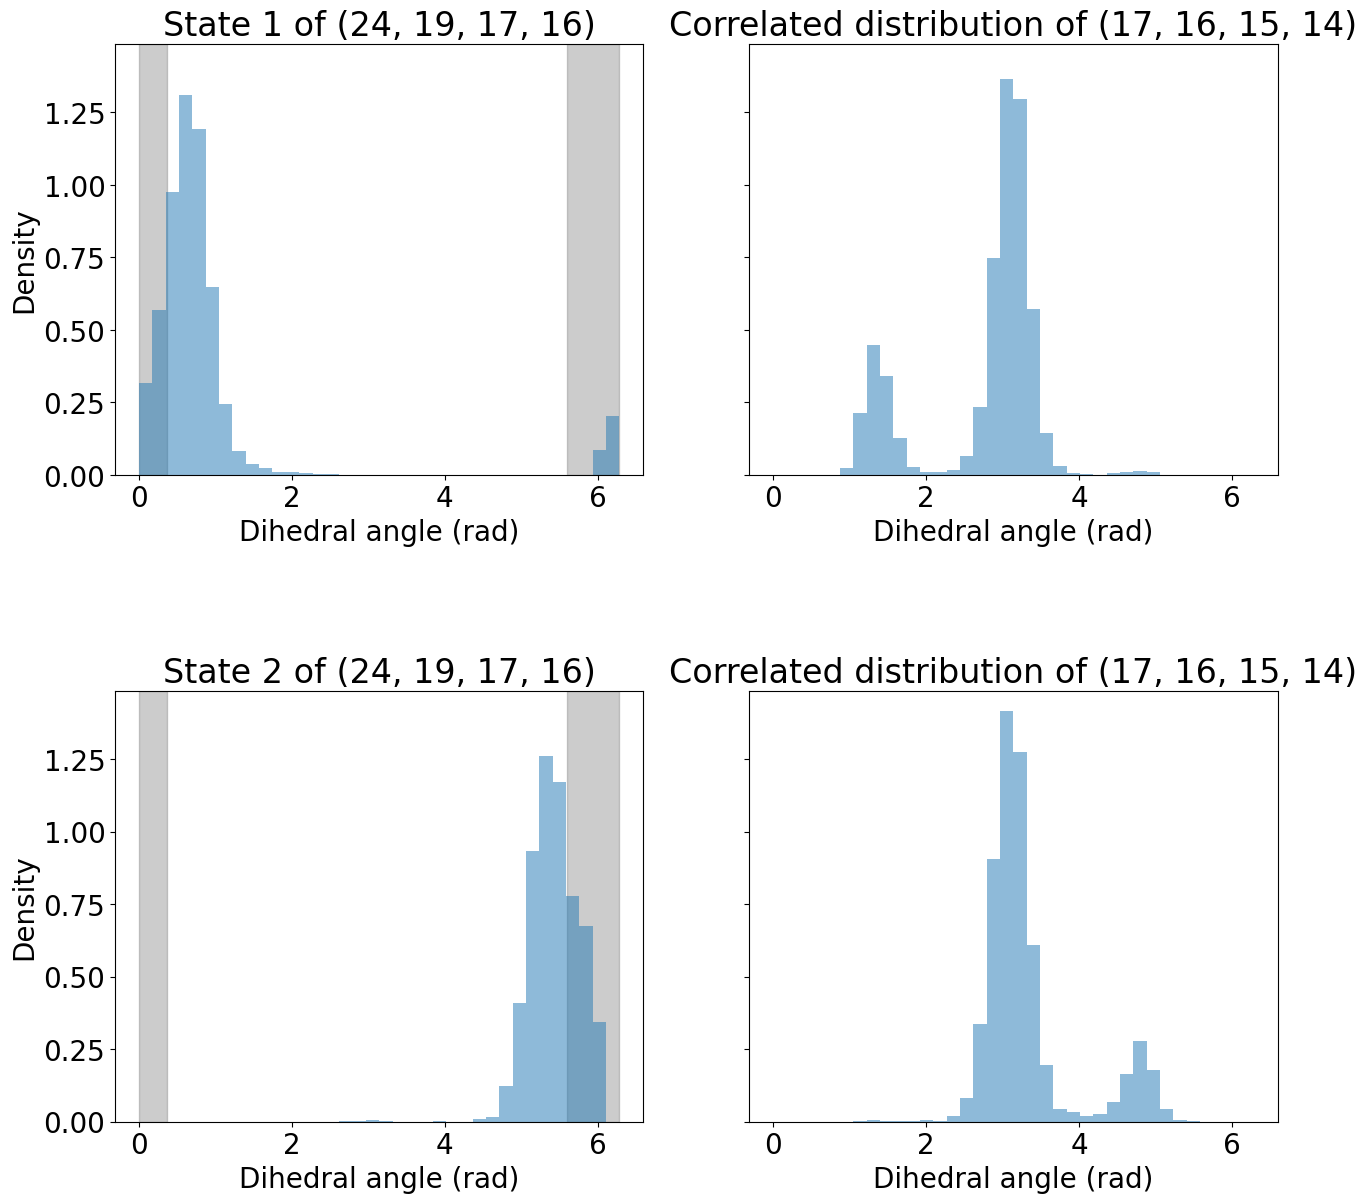

In [44]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
ax[0][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[0][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(xHist, yHists[0], width=binsize, alpha=0.5)
ax[0][0].set_xlabel("Dihedral angle (rad)")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[0][1].bar(xHist, yHists[1], width=binsize, alpha=0.5)
ax[0][1].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(xHist2, yHists2[0], width=binsize, alpha=0.5)
ax[1][0].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[1][1].bar(xHist2, yHists2[1], width=binsize, alpha=0.5)
ax[1][1].set_xlabel("Dihedral angle (rad)")